In [1]:
!pip install fastai==2.7.9
!pip install fastkaggle==0.0.7
!pip install fasterai==0.1.11
!pip install ipython-autotime==0.3.1
!pip install torch==1.12.1
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 5.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 747.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 46.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.12
    Uninstalling fastai-2.7.12:
      Successfully uninstalled fastai-2.7.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency co

In [2]:
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.data.all import *
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
from fastai.fp16_utils import *

from fasterai.sparse.all import *
from fasterai.core.criteria import *
from fasterai.regularize.all import *

from fastkaggle import *

import torch
import torch.nn as nn
import torch.nn.functional as F


set_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


time: 3.21 s (started: 2023-05-15 12:41:36 +00:00)


In [3]:
@patch
def custom_plot_losses(self: Recorder, skip_start=5, with_valid=True):
    fig2 = plt.figure("Figure 2")

    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_loss') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train loss')
    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_loss') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid loss')
        plt.legend()

    
@patch
def custom_plot_values(self: Recorder, skip_start=5, with_valid=True):
    fig3 = plt.figure("Figure 3")
    
    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_accuracy') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train accuracy')

    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_accuracy') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid accuracy')
        plt.legend()

time: 1.62 ms (started: 2023-05-15 12:41:39 +00:00)


In [4]:
comp = 'paddy-diseases/paddy-diseases'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

time: 15.1 s (started: 2023-05-15 12:41:39 +00:00)


In [5]:
dls = ImageDataLoaders.from_folder(path/"train", 
                                   valid_pct=0.25, 
                                   item_tfms=Resize(256), 
                                   batch_tfms=aug_transforms(   size=64, 
                                                                min_scale=0.75,
                                                                max_rotate=10., 
                                                                min_zoom=0.8, 
                                                                max_zoom=1.2, 
                                                            
                                                            ), 
                                   bs=32)

time: 8.1 s (started: 2023-05-15 12:41:54 +00:00)


In [7]:
sp_cb=[
#       GradientAccumulation(32), 
      SparsifyCallback(sparsity=12.5, 
                         granularity='filter', 
                         context='local', 
                         criteria=large_final, 
                         schedule=one_cycle),

]

time: 879 µs (started: 2023-05-15 12:42:23 +00:00)


In [8]:
model = vgg16_bn(num_classes=10)


time: 3.65 s (started: 2023-05-15 12:42:23 +00:00)


In [9]:
learn = Learner(dls, 
                model, 
                metrics=[accuracy,
                         error_rate,
                        ])
learn.unfreeze()
learn.recorder.train_metrics = True
learn.path = Path("/kaggle/working/")

time: 26.4 ms (started: 2023-05-15 12:42:27 +00:00)


Pruning of filter until a sparsity of [12.5]%
Saving Weights at epoch 0


epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,2.249981,0.183173,0.816827,2.062304,0.282692,0.717308,01:53
1,2.174404,0.214744,0.785256,2.014611,0.292788,0.707212,01:37
2,2.075156,0.243590,0.756410,1.981376,0.302885,0.697115,01:35
3,2.051958,0.263141,0.736859,1.932571,0.341827,0.658173,01:36
4,2.035957,0.283814,0.716186,1.909917,0.326442,0.673558,01:37
5,1.988751,0.290224,0.709776,1.841091,0.379327,0.620673,01:36
6,1.946339,0.315064,0.684936,1.790068,0.389904,0.610096,01:36
7,1.902450,0.341346,0.658654,1.743861,0.405288,0.594712,01:35
8,1.821720,0.364103,0.635897,1.648679,0.445673,0.554327,01:37
9,1.794003,0.387019,0.612981,1.608355,0.455769,0.544231,01:36


Sparsity at the end of epoch 0: [0.04]%
Sparsity at the end of epoch 1: [0.04]%
Sparsity at the end of epoch 2: [0.05]%
Sparsity at the end of epoch 3: [0.05]%
Sparsity at the end of epoch 4: [0.06]%
Sparsity at the end of epoch 5: [0.07]%
Sparsity at the end of epoch 6: [0.08]%
Sparsity at the end of epoch 7: [0.09]%
Sparsity at the end of epoch 8: [0.11]%
Sparsity at the end of epoch 9: [0.12]%
Sparsity at the end of epoch 10: [0.14]%
Sparsity at the end of epoch 11: [0.16]%
Sparsity at the end of epoch 12: [0.19]%
Sparsity at the end of epoch 13: [0.22]%
Sparsity at the end of epoch 14: [0.25]%
Sparsity at the end of epoch 15: [0.28]%
Sparsity at the end of epoch 16: [0.33]%
Sparsity at the end of epoch 17: [0.37]%
Sparsity at the end of epoch 18: [0.43]%
Sparsity at the end of epoch 19: [0.49]%
Sparsity at the end of epoch 20: [0.56]%
Sparsity at the end of epoch 21: [0.64]%
Sparsity at the end of epoch 22: [0.73]%
Sparsity at the end of epoch 23: [0.83]%
Sparsity at the end of epo

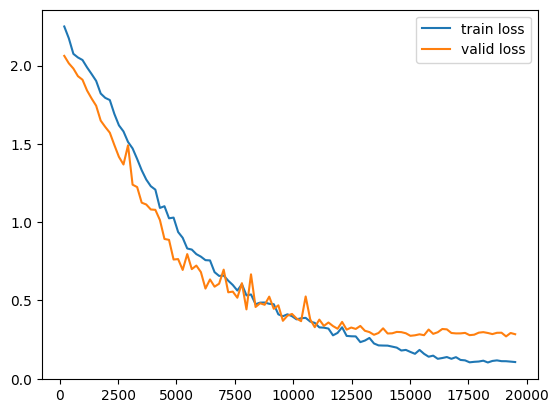

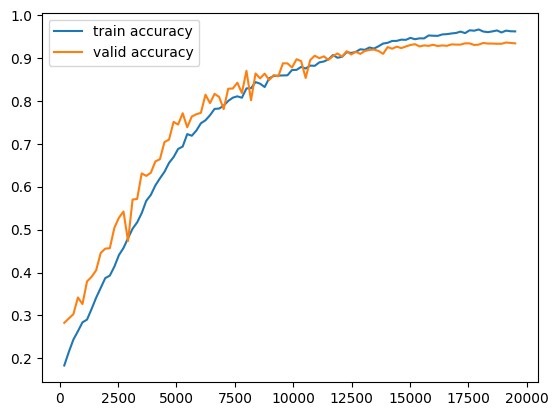

time: 2h 3min 44s (started: 2023-05-15 12:42:27 +00:00)


In [10]:
learn.fit_one_cycle(100, 3e-5, cbs=sp_cb)
                    
learn.recorder.custom_plot_losses()
learn.recorder.custom_plot_values()

In [11]:
learn.export(Path("/kaggle/working/VGG16_bn_sparsity12,5.pkl"))

time: 1.82 s (started: 2023-05-15 14:46:11 +00:00)


In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

time: 563 µs (started: 2023-05-15 14:46:13 +00:00)


In [13]:
count_parameters(learn.model)


134309962

time: 6.89 ms (started: 2023-05-15 14:46:13 +00:00)


In [14]:
pruner = Pruner()
pruned_model = pruner.prune_model(learn.model)

time: 62.1 ms (started: 2023-05-15 14:46:13 +00:00)


In [15]:
pruned_learn = Learner(dls, pruned_model.cuda(), metrics=accuracy)

time: 3.34 ms (started: 2023-05-15 14:46:13 +00:00)


In [16]:
pruned_learn.validate()

(#2) [0.28456079959869385,0.9346153736114502]

time: 14.5 s (started: 2023-05-15 14:46:13 +00:00)


In [17]:
count_parameters(pruned_learn)

118015746

time: 3.85 ms (started: 2023-05-15 14:46:27 +00:00)


In [18]:
pruned_learn.export(Path("/kaggle/working/VGG16_bn_sparsity12,5_pruned.pkl"))

time: 2.34 s (started: 2023-05-15 14:46:27 +00:00)
